In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 64)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 64)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0679 - acc: 0.3472
Epoch 00001: val_loss improved from inf to 1.65629, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_3_conv_checkpoint/001-1.6563.hdf5
36805/36805 [==============================] - 33s 907us/sample - loss: 2.0678 - acc: 0.3472 - val_loss: 1.6563 - val_acc: 0.4938
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4961 - acc: 0.5349
Epoch 00002: val_loss improved from 1.65629 to 1.44573, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_3_conv_checkpoint/002-1.4457.hdf5
36805/36805 [==============================] - 31s 851us/sample - loss: 1.4960 - acc: 0.5349 - val_loss: 1.4457 - val_acc: 0.5570
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2955 - acc: 0.6017
Epoch 00003: val_loss improved from 1.44573 to 1.

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1677 - acc: 0.9518
Epoch 00027: val_loss did not improve from 1.25977
36805/36805 [==============================] - 32s 870us/sample - loss: 0.1677 - acc: 0.9518 - val_loss: 1.6505 - val_acc: 0.6573
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1584 - acc: 0.9546
Epoch 00028: val_loss did not improve from 1.25977
36805/36805 [==============================] - 32s 869us/sample - loss: 0.1584 - acc: 0.9546 - val_loss: 1.6619 - val_acc: 0.6518
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1485 - acc: 0.9573
Epoch 00029: val_loss did not improve from 1.25977
36805/36805 [==============================] - 32s 869us/sample - loss: 0.1484 - acc: 0.9573 - val_loss: 1.7072 - val_acc: 0.6471
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1441 - acc: 0.9583
Epoch 00030: val_loss did not improve from 1.25977
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9846
Epoch 00057: val_loss did not improve from 1.25977
36805/36805 [==============================] - 32s 869us/sample - loss: 0.0586 - acc: 0.9846 - val_loss: 1.9329 - val_acc: 0.6844
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0623 - acc: 0.9832
Epoch 00058: val_loss did not improve from 1.25977
36805/36805 [==============================] - 32s 870us/sample - loss: 0.0623 - acc: 0.9832 - val_loss: 1.8808 - val_acc: 0.6846
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9844
Epoch 00059: val_loss did not improve from 1.25977
36805/36805 [==============================] - 32s 869us/sample - loss: 0.0572 - acc: 0.9844 - val_loss: 1.9059 - val_acc: 0.6911

1D_CNN_custom_multi_2_concat_DO_3_conv Model


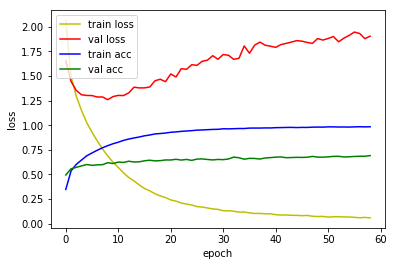

4815/4815 [==============================] - 2s 412us/sample - loss: 1.3416 - acc: 0.5931
Loss: 1.3415830714680324 Accuracy: 0.59314644

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0507 - acc: 0.3405
Epoch 00001: val_loss improved from inf to 1.60281, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_4_conv_checkpoint/001-1.6028.hdf5
36805/36805 [==============================] - 33s 893us/sample - loss: 2.0506 - acc: 0.3405 - val_loss: 1.6028 - val_acc: 0.4924
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5035 - acc: 0.5288
Epoch 00002: val_loss improved from 1.60281 to 1.38525, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_4_conv_checkpoint/002-1.3853.hdf5
36805/36805 [==============================] - 31s 854us/sample - loss: 1.5035 - acc: 0.5288 - val_loss: 1.3853 - val_acc: 0.5826
Epoch 3/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 0.2417 - acc: 0.9245
Epoch 00026: val_loss did not improve from 0.90852
36805/36805 [==============================] - 31s 851us/sample - loss: 0.2417 - acc: 0.9244 - val_loss: 1.0176 - val_acc: 0.7456
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2251 - acc: 0.9295
Epoch 00027: val_loss did not improve from 0.90852
36805/36805 [==============================] - 31s 851us/sample - loss: 0.2251 - acc: 0.9295 - val_loss: 1.0249 - val_acc: 0.7445
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2195 - acc: 0.9311
Epoch 00028: val_loss did not improve from 0.90852
36805/36805 [==============================] - 31s 852us/sample - loss: 0.2195 - acc: 0.9311 - val_loss: 1.0438 - val_acc: 0.7503
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2048 - acc: 0.9351
Epoch 00029: val_loss did not improve from 0.90852
36805/36805 [==================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0835 - acc: 0.9741
Epoch 00056: val_loss did not improve from 0.90852
36805/36805 [==============================] - 31s 851us/sample - loss: 0.0835 - acc: 0.9741 - val_loss: 1.1722 - val_acc: 0.7724
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9751
Epoch 00057: val_loss did not improve from 0.90852
36805/36805 [==============================] - 31s 848us/sample - loss: 0.0831 - acc: 0.9751 - val_loss: 1.1728 - val_acc: 0.7764
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0804 - acc: 0.9751
Epoch 00058: val_loss did not improve from 0.90852
36805/36805 [==============================] - 31s 851us/sample - loss: 0.0803 - acc: 0.9751 - val_loss: 1.2701 - val_acc: 0.7587
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0819 - acc: 0.9755
Epoch 00059: val_loss did not improve from 0.90852
36805/36805 [=====

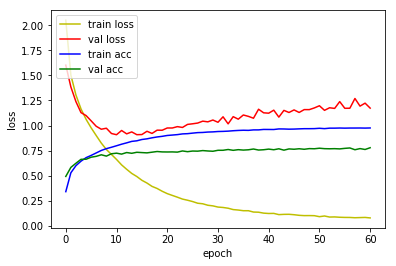

4815/4815 [==============================] - 2s 443us/sample - loss: 1.0058 - acc: 0.6922
Loss: 1.005834775067564 Accuracy: 0.69221187

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0700 - acc: 0.3324
Epoch 00001: val_loss improved from inf to 1.54189, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_5_conv_checkpoint/001-1.5419.hdf5
36805/36805 [==============================] - 35s 937us/sample - loss: 2.0698 - acc: 0.3325 - val_loss: 1.5419 - val_acc: 0.5222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5152 - acc: 0.5239
Epoch 00002: val_loss improved from 1.54189 to 1.34026, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_5_conv_checkpoint/002-1.3403.hdf5
36805/36805 [==============================] - 32s 874us/sample - loss: 1.5152 - acc: 0.5238 - val_loss: 1.3403 - val_acc: 0.5875
Epoch 3/500
36800/36805 [============================>.] 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3775 - acc: 0.8849
Epoch 00023: val_loss did not improve from 0.54121
36805/36805 [==============================] - 32s 874us/sample - loss: 0.3775 - acc: 0.8849 - val_loss: 0.5784 - val_acc: 0.8348
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3611 - acc: 0.8890
Epoch 00024: val_loss did not improve from 0.54121
36805/36805 [==============================] - 32s 878us/sample - loss: 0.3611 - acc: 0.8890 - val_loss: 0.5693 - val_acc: 0.8381
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3420 - acc: 0.8967
Epoch 00025: val_loss improved from 0.54121 to 0.53672, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_5_conv_checkpoint/025-0.5367.hdf5
36805/36805 [==============================] - 32s 877us/sample - loss: 0.3420 - acc: 0.8967 - val_loss: 0.5367 - val_acc: 0.8549
Epoch 26/500
36800/36805 [============================>.] - ET

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1290 - acc: 0.9592
Epoch 00051: val_loss did not improve from 0.50926
36805/36805 [==============================] - 32s 871us/sample - loss: 0.1290 - acc: 0.9592 - val_loss: 0.5522 - val_acc: 0.8642
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1236 - acc: 0.9596
Epoch 00052: val_loss did not improve from 0.50926
36805/36805 [==============================] - 32s 874us/sample - loss: 0.1236 - acc: 0.9596 - val_loss: 0.5466 - val_acc: 0.8772
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1224 - acc: 0.9602
Epoch 00053: val_loss did not improve from 0.50926
36805/36805 [==============================] - 32s 869us/sample - loss: 0.1224 - acc: 0.9602 - val_loss: 0.5669 - val_acc: 0.8728
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9615
Epoch 00054: val_loss did not improve from 0.50926
36805/36805 [=====

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0672 - acc: 0.9782
Epoch 00081: val_loss did not improve from 0.50926
36805/36805 [==============================] - 32s 877us/sample - loss: 0.0672 - acc: 0.9782 - val_loss: 0.5956 - val_acc: 0.8805
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0666 - acc: 0.9783
Epoch 00082: val_loss did not improve from 0.50926
36805/36805 [==============================] - 32s 864us/sample - loss: 0.0666 - acc: 0.9783 - val_loss: 0.5907 - val_acc: 0.8814
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0673 - acc: 0.9786
Epoch 00083: val_loss did not improve from 0.50926
36805/36805 [==============================] - 32s 868us/sample - loss: 0.0673 - acc: 0.9786 - val_loss: 0.5819 - val_acc: 0.8826
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0660 - acc: 0.9792
Epoch 00084: val_loss did not improve from 0.50926
36805/36805 [=====

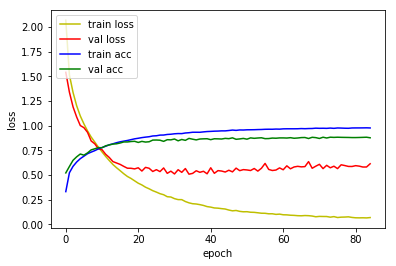

4815/4815 [==============================] - 2s 481us/sample - loss: 0.6220 - acc: 0.8351
Loss: 0.6220000506190124 Accuracy: 0.8350986

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1931 - acc: 0.2864
Epoch 00001: val_loss improved from inf to 1.55255, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_6_conv_checkpoint/001-1.5525.hdf5
36805/36805 [==============================] - 36s 971us/sample - loss: 2.1931 - acc: 0.2865 - val_loss: 1.5525 - val_acc: 0.5118
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5034 - acc: 0.5218
Epoch 00002: val_loss improved from 1.55255 to 1.27464, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_6_conv_checkpoint/002-1.2746.hdf5
36805/36805 [==============================] - 32s 882us/sample - loss: 1.5034 - acc: 0.5218 - val_loss: 1.2746 - val_acc: 0.6080
Epoch 3/500
36800/36805 [============================>.] 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.9084
Epoch 00023: val_loss improved from 0.29854 to 0.29783, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_6_conv_checkpoint/023-0.2978.hdf5
36805/36805 [==============================] - 32s 870us/sample - loss: 0.2911 - acc: 0.9084 - val_loss: 0.2978 - val_acc: 0.9150
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2785 - acc: 0.9127
Epoch 00024: val_loss improved from 0.29783 to 0.29425, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_6_conv_checkpoint/024-0.2943.hdf5
36805/36805 [==============================] - 32s 867us/sample - loss: 0.2785 - acc: 0.9127 - val_loss: 0.2943 - val_acc: 0.9199
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2640 - acc: 0.9177
Epoch 00025: val_loss did not improve from 0.29425
36805/36805 [==============================] - 32s 862us/sample - loss: 0.2641 - acc: 0.

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1213 - acc: 0.9595
Epoch 00049: val_loss did not improve from 0.23468
36805/36805 [==============================] - 32s 862us/sample - loss: 0.1213 - acc: 0.9595 - val_loss: 0.2575 - val_acc: 0.9311
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1184 - acc: 0.9600
Epoch 00050: val_loss did not improve from 0.23468
36805/36805 [==============================] - 32s 864us/sample - loss: 0.1184 - acc: 0.9600 - val_loss: 0.2480 - val_acc: 0.9352
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1148 - acc: 0.9614
Epoch 00051: val_loss did not improve from 0.23468
36805/36805 [==============================] - 32s 865us/sample - loss: 0.1149 - acc: 0.9614 - val_loss: 0.2540 - val_acc: 0.9320
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1102 - acc: 0.9644
Epoch 00052: val_loss did not improve from 0.23468
36805/36805 [=====

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0603 - acc: 0.9796
Epoch 00079: val_loss did not improve from 0.23468
36805/36805 [==============================] - 32s 863us/sample - loss: 0.0603 - acc: 0.9796 - val_loss: 0.2635 - val_acc: 0.9418
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9815
Epoch 00080: val_loss did not improve from 0.23468
36805/36805 [==============================] - 32s 874us/sample - loss: 0.0555 - acc: 0.9815 - val_loss: 0.2873 - val_acc: 0.9387
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9810
Epoch 00081: val_loss did not improve from 0.23468
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0537 - acc: 0.9810 - val_loss: 0.2817 - val_acc: 0.9394
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0582 - acc: 0.9810
Epoch 00082: val_loss did not improve from 0.23468
36805/36805 [=====

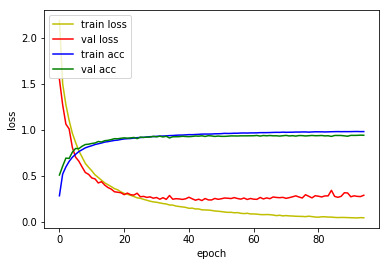

4815/4815 [==============================] - 2s 471us/sample - loss: 0.2965 - acc: 0.9121
Loss: 0.2964714678710371 Accuracy: 0.91214955

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1833 - acc: 0.2830
Epoch 00001: val_loss improved from inf to 1.44206, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_7_conv_checkpoint/001-1.4421.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 2.1835 - acc: 0.2831 - val_loss: 1.4421 - val_acc: 0.5567
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3616 - acc: 0.5592
Epoch 00002: val_loss improved from 1.44206 to 1.08113, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_7_conv_checkpoint/002-1.0811.hdf5
36805/36805 [==============================] - 33s 905us/sample - loss: 1.3614 - acc: 0.5592 - val_loss: 1.0811 - val_acc: 0.6620
Epoch 3/500
36800/36805 [============================>.] -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1921 - acc: 0.9373
Epoch 00024: val_loss improved from 0.18740 to 0.17088, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_7_conv_checkpoint/024-0.1709.hdf5
36805/36805 [==============================] - 33s 891us/sample - loss: 0.1921 - acc: 0.9373 - val_loss: 0.1709 - val_acc: 0.9499
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1835 - acc: 0.9399
Epoch 00025: val_loss did not improve from 0.17088
36805/36805 [==============================] - 33s 895us/sample - loss: 0.1835 - acc: 0.9399 - val_loss: 0.1942 - val_acc: 0.9399
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1741 - acc: 0.9450
Epoch 00026: val_loss did not improve from 0.17088
36805/36805 [==============================] - 33s 899us/sample - loss: 0.1741 - acc: 0.9450 - val_loss: 0.2058 - val_acc: 0.9380
Epoch 27/500
36800/36805 [============================>.] - ET

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0754 - acc: 0.9735
Epoch 00052: val_loss did not improve from 0.15055
36805/36805 [==============================] - 32s 876us/sample - loss: 0.0754 - acc: 0.9735 - val_loss: 0.1616 - val_acc: 0.9560
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0739 - acc: 0.9737
Epoch 00053: val_loss did not improve from 0.15055
36805/36805 [==============================] - 32s 873us/sample - loss: 0.0739 - acc: 0.9736 - val_loss: 0.1666 - val_acc: 0.9567
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0740 - acc: 0.9747
Epoch 00054: val_loss did not improve from 0.15055
36805/36805 [==============================] - 32s 879us/sample - loss: 0.0740 - acc: 0.9747 - val_loss: 0.1666 - val_acc: 0.9571
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9762
Epoch 00055: val_loss did not improve from 0.15055
36805/36805 [=====

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9852
Epoch 00082: val_loss did not improve from 0.15055
36805/36805 [==============================] - 32s 880us/sample - loss: 0.0408 - acc: 0.9852 - val_loss: 0.1771 - val_acc: 0.9581
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9865
Epoch 00083: val_loss did not improve from 0.15055
36805/36805 [==============================] - 33s 887us/sample - loss: 0.0389 - acc: 0.9865 - val_loss: 0.1787 - val_acc: 0.9604
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9871
Epoch 00084: val_loss did not improve from 0.15055
36805/36805 [==============================] - 33s 890us/sample - loss: 0.0389 - acc: 0.9871 - val_loss: 0.1822 - val_acc: 0.9585
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9875
Epoch 00085: val_loss did not improve from 0.15055
36805/36805 [=====

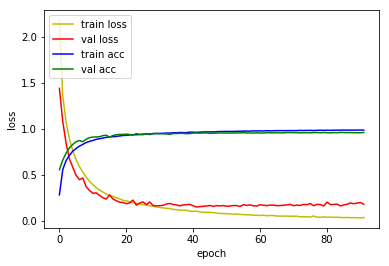

4815/4815 [==============================] - 2s 508us/sample - loss: 0.1965 - acc: 0.9418
Loss: 0.1964829167411087 Accuracy: 0.9418484

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0582 - acc: 0.3245
Epoch 00001: val_loss improved from inf to 1.24283, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_8_conv_checkpoint/001-1.2428.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.0582 - acc: 0.3245 - val_loss: 1.2428 - val_acc: 0.6268
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2003 - acc: 0.6080
Epoch 00002: val_loss improved from 1.24283 to 0.81819, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_8_conv_checkpoint/002-0.8182.hdf5
36805/36805 [==============================] - 33s 907us/sample - loss: 1.2002 - acc: 0.6080 - val_loss: 0.8182 - val_acc: 0.7468
Epoch 3/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1693 - acc: 0.9442
Epoch 00023: val_loss did not improve from 0.14859
36805/36805 [==============================] - 33s 899us/sample - loss: 0.1693 - acc: 0.9441 - val_loss: 0.1637 - val_acc: 0.9471
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1582 - acc: 0.9489
Epoch 00024: val_loss improved from 0.14859 to 0.14739, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_8_conv_checkpoint/024-0.1474.hdf5
36805/36805 [==============================] - 33s 897us/sample - loss: 0.1582 - acc: 0.9489 - val_loss: 0.1474 - val_acc: 0.9529
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1560 - acc: 0.9478
Epoch 00025: val_loss improved from 0.14739 to 0.14627, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_8_conv_checkpoint/025-0.1463.hdf5
36805/36805 [==============================] - 33s 896us/sample - loss: 0.1559 - acc: 0.9478 - val_lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9796
Epoch 00050: val_loss did not improve from 0.12526
36805/36805 [==============================] - 33s 889us/sample - loss: 0.0596 - acc: 0.9796 - val_loss: 0.1590 - val_acc: 0.9597
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9783
Epoch 00051: val_loss did not improve from 0.12526
36805/36805 [==============================] - 33s 887us/sample - loss: 0.0631 - acc: 0.9783 - val_loss: 0.1370 - val_acc: 0.9620
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0599 - acc: 0.9802
Epoch 00052: val_loss did not improve from 0.12526
36805/36805 [==============================] - 33s 893us/sample - loss: 0.0599 - acc: 0.9802 - val_loss: 0.1537 - val_acc: 0.9590
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9817
Epoch 00053: val_loss did not improve from 0.12526
36805/36805 [==================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9902
Epoch 00080: val_loss did not improve from 0.12526
36805/36805 [==============================] - 33s 888us/sample - loss: 0.0307 - acc: 0.9902 - val_loss: 0.1957 - val_acc: 0.9599
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9886
Epoch 00081: val_loss did not improve from 0.12526
36805/36805 [==============================] - 33s 890us/sample - loss: 0.0323 - acc: 0.9886 - val_loss: 0.1718 - val_acc: 0.9627
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9901
Epoch 00082: val_loss did not improve from 0.12526
36805/36805 [==============================] - 33s 886us/sample - loss: 0.0272 - acc: 0.9901 - val_loss: 0.1720 - val_acc: 0.9637
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9904
Epoch 00083: val_loss did not improve from 0.12526
36805/36805 [=====

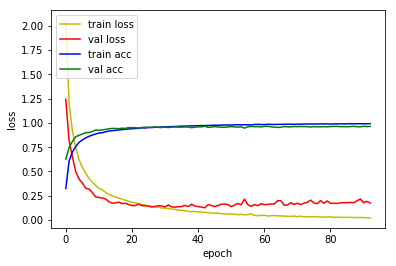

4815/4815 [==============================] - 2s 502us/sample - loss: 0.2091 - acc: 0.9421
Loss: 0.20914874090924318 Accuracy: 0.94205606



In [10]:
base = '1D_CNN_custom_multi_2_concat_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
_______________________________________________________________

4815/4815 [==============================] - 2s 513us/sample - loss: 0.6220 - acc: 0.8351
Loss: 0.6220000506190124 Accuracy: 0.8350986

1D_CNN_custom_multi_2_concat_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 64)    384         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 64)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPoolin

4815/4815 [==============================] - 3s 560us/sample - loss: 0.1965 - acc: 0.9418
Loss: 0.1964829167411087 Accuracy: 0.9418484

1D_CNN_custom_multi_2_concat_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 64)    384         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 64)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPoolin

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
_______________________________________________________________

4815/4815 [==============================] - 3s 527us/sample - loss: 0.7413 - acc: 0.8482
Loss: 0.7413235825541606 Accuracy: 0.84818274

1D_CNN_custom_multi_2_concat_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 64)    384         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 64)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPooli

4815/4815 [==============================] - 3s 578us/sample - loss: 0.2347 - acc: 0.9470
Loss: 0.2346560198484861 Accuracy: 0.9470405

1D_CNN_custom_multi_2_concat_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 64)    384         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 64)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPoolin